In [52]:
# coding: utf-8
import re
import math
import csv
import sys
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from obspy import UTCDateTime, Stream, Trace

%matplotlib inline

In [53]:
def unpackAfile(infile):

# == opening Afile ==
    b = os.path.getsize(infile)
    FH = open(infile, 'rb')
    line = FH.read(b)
    fileHeader = struct.unpack("<4s3h6bh6s", line[0:24])

    fileLength = fileHeader[3]
    port = fileHeader[10]
    # FirstStn = fileHeader[11][0:4].decode('ASCII').rstrip()
# =================================Header=================================

    portHeader = []
    for i in range(24, port * 32, 32):
        port_data = struct.unpack("<4s4s3sbh2b4s12b", line[i:i+32])
        portHeader.append(port_data)

# =================================Data===================================

    dataStartByte = 24+int(port)*32
    dataPoint = 3*int(port)*int(fileLength)*100
    times = int(port)*3*4
    data = []

    data = struct.unpack("<%di" % dataPoint, line[dataStartByte:dataStartByte + dataPoint*4])


    portHeader = np.array(portHeader)
    data = np.array(data)
    idata = data.reshape((3,port,fileLength*100),order='F')

#== write to obspy Stream --
    sttime = UTCDateTime(fileHeader[1], fileHeader[4], fileHeader[5], fileHeader[6], fileHeader[7], fileHeader[8], fileHeader[2])
    npts = fileHeader[3]*fileHeader[9]
    samp = fileHeader[9]
    afst = Stream()
    
    for stc in range(fileHeader[10]):
        stn = portHeader[stc][0].decode('ASCII').rstrip()
        instrument = portHeader[stc][1].decode('ASCII').rstrip()
        loc = '0'+str(portHeader[stc][6].decode('ASCII'))
        net = str(portHeader[stc][7].decode('ASCII')).rstrip()
        GPS = int(portHeader[stc][3])
        
        # remove GPS unlock or broken station
        if ( GPS == 1 or GPS == 2 ):
            chc = 0
            if instrument == 'FBA':
                chc = 1
            elif instrument == 'SP':
                chc = 4
            elif instrument == 'BB':
                chc = 7
            
            for ch in range(3):
                chn = 'Ch'+str(chc+ch)
                
                stats = {'network': net, 'station': stn, 'location': loc,
                        'channel': chn, 'npts': npts, 'sampling_rate': samp,
                        'starttime': sttime}
                
                data = np.array(idata[ch][stc], dtype=float)
                sttmp = Stream([Trace(data=data, header=stats)])
                afst += sttmp

    return afst

In [54]:
def unpackPfile(infile):
    
    with open(infile) as f:
        lines = f.readlines()
    
    tmp = lines[0]
    year = int(tmp[1:5])
    month = int(tmp[5:7])
    day = int(tmp[7:9])
    hour = int(tmp[9:11])
    minute = int(tmp[11:13])
    sec = float(tmp[13:19])
    
    lat_d = float(tmp[19:21])
    lat_m = float(tmp[21:26])
    
    lon_d = float(tmp[26:29])
    lon_m = float(tmp[29:34])
    
    dt = datetime(year,month,day,hour,minute,int(sec//1),int(sec%1 * 1000000))
    mag = float(tmp[40:44])

    pfile_info = {}
    pfile_info["ori_time"] = dt
    pfile_info["mag"] = mag
    pfile_info["lat"] = lat_d + lat_m/60.0
    pfile_info["lon"] = lon_d + lon_m/60.0
    
    intensity = {}
    arrival_time = {}
    weighting = {}
    pga = {}
    for i in lines[1:]:
        sta = i[:5].strip() # strip 去掉左右空格
        weighting[sta] = int(float(i[35:39]))
        if i[76:77]==" ":
            intensity[sta] = int(0)
        else:
            intensity[sta] = int(i[76:77])
        if i[78:83]=="     ":
            pga[sta] = int(0)
        else:
            pga[sta] = (i[78:83])
        arrival_time[sta] = pfile_info["ori_time"].replace(minute=int(i[21:23]),second=0,microsecond=0) + timedelta(seconds=float(i[23:29]))
        arrival_time[sta].microsecond * 10**-6
    pfile_info["intensity"] = intensity
    pfile_info["arrival_time"] = arrival_time

    pfile_info["weighting"] = weighting
    pfile_info["pga"] = pga
    
    return pfile_info

In [55]:
def batch_showname(path):
    afile_name=[]
    pfile_name=[]
    for fname in os.listdir(path):
        if fname[-3]=="A":
            afile_name.append(fname)
        if fname[-3]=="P":
            pfile_name.append(fname)
    return afile_name,pfile_name

In [56]:
def st_Pd_PGV_I(Afile,Pfile):
    
    station_list=[]
    for i,j in Pfile['intensity'].items():
        if j >0:
            station_list.append(i)
    st_list_all=[]
    for i in Afile:
        if i.stats.channel=="Ch1" and i.stats.location=="01" and i.stats.station in station_list:
            st_list_all.append(i)
    scores=[]
    for st_list in st_list_all:
        tr= st_list.copy()
        tr.detrend()
        station = st_list.stats.station
        tr.data = tr.data * 3.1153**(-4)
        tr.integrate()
        tr.detrend()
        tr.filter('highpass', freq=1.0, corners=2, zerophase=True)
        PGV_true = max(abs(tr.data))
        tr.plot();
        tr.integrate()
        tr.detrend()
        tr.filter('highpass', freq=1.0, corners=2, zerophase=True)
        tr.plot();
        ptime = Pfile["arrival_time"][station]
        Pfile["arrival_time"][station]
        ptime_obspy = UTCDateTime(ptime.year, ptime.month, ptime.day, ptime.hour, ptime.minute, ptime.second, ptime.microsecond)
        parrival = int(( ptime_obspy - tr.stats.starttime ) * tr.stats.sampling_rate )
        Pd=max(abs(tr.data[parrival:parrival+300]))
        PGV_cal=10**(0.920*np.log10(Pd) +1.642)
        for i,j in Pfile['intensity'].items():
            if i == st_list.stats.station:
                intensity_true = str(j)
        for i,j in Pfile['pga'].items():
            if i == st_list.stats.station:
                PGA = str(j)
        if int(round(2.14*np.log10(PGV_cal)+1.89))>=0:
            intensity_cal=str(int(round(2.14*np.log10(PGV_cal)+1.89)))
        else:
            intensity_cal=str(0)
        max_time=np.argmax(abs(tr.data))
        l_time = ((max_time-parrival)/tr.stats.sampling_rate)-3
        st_Pd_PGV_I={}
        st_Pd_PGV_I["station"] = station
        st_Pd_PGV_I["Pd"] = Pd
        st_Pd_PGV_I["PGA"] = PGA
        st_Pd_PGV_I["PGV_true"] = PGV_true
        st_Pd_PGV_I["PGV_cal"] = PGV_cal
        st_Pd_PGV_I["I_true"] = intensity_true
        st_Pd_PGV_I["I_cal"] = intensity_cal
        st_Pd_PGV_I["l_time"] = l_time
        scores.append(st_Pd_PGV_I)
        df1 = pd.DataFrame(scores)
    return df1,st_list_all

In [57]:
def station_data(df1,Pfile):
    #讀取測站資料
    with open("c:\\datasrc\\hypo3d.sta","r") as fp:
        fp.readline()
        stalist=fp.readlines()
    stainfo={}
    for i in stalist:
        i=i.strip()
        #print(i)

        lat_d = float(i[4:6])
        lat_m = float(i[6:11])
        lon_d = float(i[11:14])
        lon_m = float(i[14:19])

        lat = lat_d + lat_m/60.0
        lon = lon_d + lon_m/60.0
        sta = i.split()[-1]
        stainfo[sta]=[lon , lat]
    sta_lalon={}
    for i in df1['station']:
        if i in stainfo.keys():
            sta_lalon[i]=stainfo[i]
    for i in st_Pd_PGV_I(Afile,Pfile)['station']:
        if i=="ESA":
            sta_lalon['ESA']=[121.8439,24.5757]
    with open("lonlat.txt","w") as fp:
        for i in sta_lalon.keys():
            fp.write(str(sta_lalon[i][0])+" "+str(sta_lalon[i][1])+"\n")
    aa=sta_lalon
    lon_max=0.0
    lon_min=180.0
    for i in aa.values():
        if i[0]>lon_max:
            lon_max=i[0]
        if i[0]<lon_min:
            lon_min=i[0]
    lat_max=0.0
    lat_min=90.0
    for i in aa.values():
        if i[1]>lat_max:
            lat_max=i[1]
        if i[1]<lat_min:
            lat_min=i[1]
    #將地震經緯寫成txt檔
    with open("E_lonlat.txt","w") as fp:
        ff=str(Pfile["lon"])+" "+str(Pfile["lat"])
        fp.write(ff)
    with open("intensity.txt","w") as fp:
        j=0
        for i in sta_lalon.keys():
            fp.write(str(sta_lalon[i][0])+" "+str(sta_lalon[i][1]-0.02)+" "+"("+str(df1.iloc[j,5])+","+str(df1.iloc[j,6])+","+str(df1.iloc[j,7])+")"+"\n")
            j=j+1
    return lon_max,lon_min,lat_max,lat_min

In [58]:
def accuracy(data):
    true=0
    false=0
    all_data=len(data)
    for i in data.index:
        if data.loc[i,"I_true"] == data.loc[i,"I_cal"]:
            true=true+1
        else:
            false=false+1
    true_rate=true/all_data
    false_rate=false/all_data
    return true_rate,false_rate

In [59]:
def accuracy_2(data):
    true=0
    false=0
    all_data=len(data)
    for i in data.index:
        if data.loc[i,"I_true"] == data.loc[i,"I_cal"] or int(data.loc[i,"I_true"])+1 == int(data.loc[i,"I_cal"]) or int(data.loc[i,"I_true"])-1 == int(data.loc[i,"I_cal"]):
            true=true+1
        else:
            false=false+1
    true_rate=true/all_data
    false_rate=false/all_data
    return true_rate,false_rate

In [60]:
path = ("D:\\專題\\Utaipei-Seismology-master\\EEW-for-urban-area\\2015-felt-01")
path_1 = ("D:\\專題\\Utaipei-Seismology-master\\EEW-for-urban-area\\2015-felt-01\\")

In [61]:
Afile=unpackAfile(path_1+batch_showname(path)[0][11])
Pfile=unpackPfile(path_1+batch_showname(path)[1][11])

C:\ProgramData\Anaconda3\lib\site-packages\obspy\imaging\util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
C:\ProgramData\Anaconda3\lib\site-packages\obspy\imaging\waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


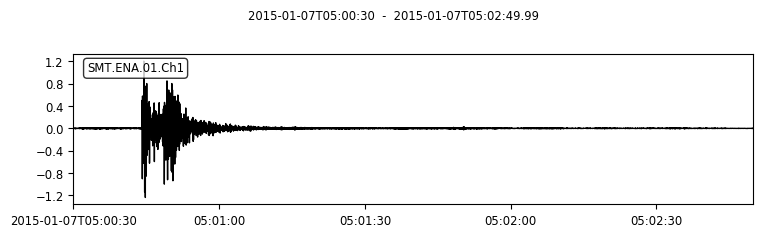

C:\ProgramData\Anaconda3\lib\site-packages\obspy\imaging\util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
C:\ProgramData\Anaconda3\lib\site-packages\obspy\imaging\waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


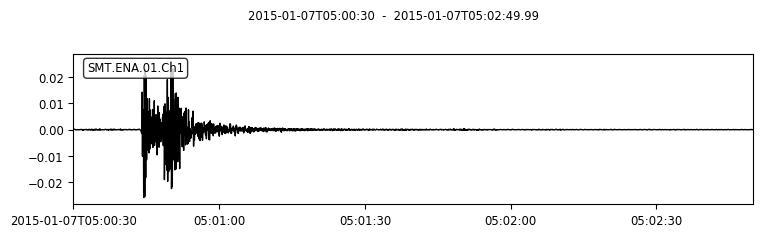

NameError: name 'pd' is not defined

In [62]:
st_Pd_PGV_I(Afile,Pfile)

In [ ]:
scores=[]
for i in range(len(batch_showname(path)[0])):
    Afile=unpackAfile(path_1+batch_showname(path)[0][i])
    Pfile=unpackPfile(path_1+batch_showname(path)[1][i])
    data=st_Pd_PGV_I(Afile,Pfile)
    print(batch_showname(path)[0][i][0:-4])
    for i in range(len(data)):
        if float(data.iloc[i,3])<0.001:
            data.drop([i], inplace=True)
            break    
    if len(data)>3:
        print(data)
        print("測站數量："+str(len(data)))
        print("正確率："+str(accuracy(data)[0]))
        print("錯誤率："+str(accuracy(data)[1]))
        print("正負一")
        print("正確率："+str(accuracy_2(data)[0]))
        print("錯誤率："+str(accuracy_2(data)[1]))
        accuracy_11={}
        accuracy_11["accuracy"]=accuracy(data)[0]
        accuracy_11["loss"]=accuracy(data)[1]
        accuracy_11["accuracy_1"]=accuracy_2(data)[0]
        accuracy_11["loss_1"]=accuracy_2(data)[1]
        
        
        scores.append(accuracy_11)
        df = pd.DataFrame(scores)
        print("----------------------------------------------------------------------------------------")

In [ ]:
for i in range(len(batch_showname(path)[0])):
    Afile=unpackAfile(path_1+batch_showname(path)[0][i])
    Pfile=unpackPfile(path_1+batch_showname(path)[1][i])
    print("讀檔完成")
    file=batch_showname(path)[0][i][0:-4]
    station_data(st_Pd_PGV_I(Afile,Pfile),Pfile)
    lon_max=(station_data(st_Pd_PGV_I(Afile,Pfile),Pfile))[0]
    lon_min=(station_data(st_Pd_PGV_I(Afile,Pfile),Pfile))[1]
    lat_max=(station_data(st_Pd_PGV_I(Afile,Pfile),Pfile))[2]
    lat_min=(station_data(st_Pd_PGV_I(Afile,Pfile),Pfile))[3]
    print("繪圖中...")

    with open("1207plot.bat","w") as fp:
        fp.write(f"gmt begin {file} png \n")
        fp.write(f"    gmt psbasemap -R{lon_min-0.3}/{lon_max+0.3}/{lat_min-0.2}/{lat_max+0.2} -JM6i -Ba0.5f0.5 \n")
        fp.write(f"    gmt plot TaiwanCOunty.gmt -R{lon_min-0.3}/{lon_max+0.3}/{lat_min-0.2}/{lat_max+0.2} -JM6i \n")
        fp.write(f"    gmt plot lonlat.txt -R{lon_min-0.3}/{lon_max+0.3}/{lat_min-0.2}/{lat_max+0.2} -St0.5 -G255/255/0 \n")
        fp.write(f"    gmt plot E_lonlat.txt -R{lon_min-0.3}/{lon_max+0.3}/{lat_min-0.2}/{lat_max+0.2} -Sa0.5 -G255/0/0  \n")
        fp.write(f"    gmt text intensity.txt -R{lon_min-0.3}/{lon_max+0.3}/{lat_min-0.2}/{lat_max+0.2}  \n")
        fp.write(f"gmt end show")
    os.system("1207plot.bat")

    print(file+"圖檔完成")
    print("----------------------")

In [ ]:
#https://scweb.cwb.gov.tw/zh-tw/station